# Finding h- and W-Theta at h-

In [1]:
# import the basics
import pysr
from pysr import PySRRegressor

import xarray as xr
import netCDF4 as nc
import h5netcdf
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from glob import glob

# sara also has
from netCDF4 import Dataset
import os

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
folder_path = '/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/'

nc_test1 = nc.Dataset(os.path.join(folder_path, 'Ug2Q010_I.nc'), mode='r')
z_256 = nc_test1.variables['z'][:]
zh_257 = nc_test1.variables['zh'][:]
t_120 = nc_test1.variables['time'][:]

nc_test2 = nc.Dataset(os.path.join(folder_path, 'Ug2Q010_IV.nc'), mode='r')
z_384 = nc_test2.variables['z'][:]
zh_385 = nc_test2.variables['zh'][:]
t_90 = nc_test2.variables['time'][:]
print(len(z_256), len(zh_257), len(t_120), len(z_384), len(zh_385), len(t_90))

256 257 120 384 385 90


In [3]:
def read_data(filepath):
    """
    Reads in each dataset and returns an xarray dataset
    """

    ds_thm = xr.open_dataset(f"{filepath}",
                             decode_times=False, group="thermo")
    ds_bud = xr.open_dataset(f"{filepath}",
                            decode_times=False, group="budget")
    ds_def = xr.open_dataset(f"{filepath}", 
                             decode_times=False, group="default")
    ds = xr.merge([ds_thm, ds_bud, ds_def], join="inner")

    if len(ds.time) == 90:
        ds = ds.assign_coords({"time": t_90}).swap_dims({"time":"time"})
    elif len(ds.time) == 120:
        ds = ds.assign_coords({"time": t_120}).swap_dims({"time":"time"})

    if len(ds.z) == 256:
        ds = ds.assign_coords({"z": z_256}).swap_dims({"z":"z"})
    elif len(ds.z) == 384:
        ds = ds.assign_coords({"z": z_384}).swap_dims({"z":"z"})

    if len(ds.zh) == 257:
        ds = ds.assign_coords({"zh": zh_257}).swap_dims({"zh":"zh"})
    elif len(ds.zh) == 385:
        ds = ds.assign_coords({"zh": zh_385}).swap_dims({"zh":"zh"})

    return ds

* Four inversion cases, i being the strong inversion and iv the weakest (temperature inversion that occurs at the top of the ABL)
* Surface Heating (Q): Influences the heat profile.
* Wind (Ug): Imposed wind; affects the movement and distribution of air properties.
* Inversion (dtheta/dz): Impacts the stratification and stability, influencing PBL growth.

In [4]:
# renaming files according to their inversion strength, wind, and surface heating
folder_path = '/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/'
files = glob(f"{folder_path}/*")

for file in files:
    print(file)

/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug16Q006_I.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug8Q006_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug8Q003_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug16Q010_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug2Q024_I.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug8Q003_III.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug16Q001_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug2Q01_III.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug16Q003_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug2Q010_I.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug1Q01_II.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug8Q003_II.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug16Q000_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug2Q010_IV.nc
/Users/gretavanzetten/Desktop/LE

In [5]:
# put all file names into one list for accessability later
file_names = [
    "Ug16Q006_I.nc", 
    "Ug8Q006_IV.nc", 
    "Ug8Q003_IV.nc",
    "Ug16Q010_IV.nc",
    "Ug2Q024_I.nc",
    "Ug8Q003_III.nc",
    "Ug16Q001_IV.nc",
    "Ug2Q01_III.nc",
    "Ug16Q003_IV.nc",
    "Ug2Q010_I.nc",
    "Ug1Q01_II.nc",
    "Ug8Q003_II.nc",
    #"Ug16Q000_IV.nc",
    "Ug2Q010_IV.nc",
    "Ug16Q006_IV.nc"
]

In [6]:
# put all the files into one dataset
datasets = [
    read_data(files[0]),
    read_data(files[1]),
    read_data(files[2]),
    read_data(files[3]),
    read_data(files[4]),
    read_data(files[5]),
    read_data(files[6]),
    read_data(files[7]),
    read_data(files[8]),
    read_data(files[9]),
    read_data(files[10]),
    read_data(files[11]),
    # no Ug16Q000_IV.nc
    read_data(files[13]),
    read_data(files[14])
]

In [7]:
# print short and long names of variables within each group 
### default - velocity terms
### thermo - buoyancy or theta
### budget - TKE or heat budget terms

df = nc.Dataset(files[10], mode='r')
for group_name, group in df.groups.items():
    print(f"Group: {group_name}")
    for var_name, var in group.variables.items():
        long_name = var.getncattr('long_name') if 'long_name' in var.ncattrs() else 'No long name'
        dimensions = var.dimensions if hasattr(var, 'dimensions') else 'No dimensions attribute'
        print(f"Variable: {var_name}, Long Name: {long_name}, Dimensions: {dimensions}")
    print("\n")
df.close()

Group: default
Variable: iter, Long Name: Iteration number, Dimensions: ('time',)
Variable: area, Long Name: Fractional area contained in mask, Dimensions: ('time', 'z')
Variable: areah, Long Name: Fractional area contained in mask, Dimensions: ('time', 'zh')
Variable: eft, Long Name: eft, Dimensions: ('time', 'z')
Variable: eft_3, Long Name: Moment 3 of the eft, Dimensions: ('time', 'z')
Variable: eft_4, Long Name: Moment 4 of the eft, Dimensions: ('time', 'z')
Variable: eft_diff, Long Name: Diffusive flux of the eft, Dimensions: ('time', 'zh')
Variable: eft_w, Long Name: Turbulent flux of the eft, Dimensions: ('time', 'zh')
Variable: eft_grad, Long Name: Gradient of the eft, Dimensions: ('time', 'zh')
Variable: eft_2, Long Name: Moment 2 of the eft, Dimensions: ('time', 'z')
Variable: eft_path, Long Name: eft path, Dimensions: ('time',)
Variable: eft_flux, Long Name: Total flux of the eft, Dimensions: ('time', 'zh')
Variable: sft, Long Name: sft, Dimensions: ('time', 'z')
Variable: s

### Helpful Variable Names
* pbl_height = 'zi' 
* mean potential temperature = 'th'
* heat_flux = 'th_flux' 
* time = 'time'

Want to look at $\theta$ flux and find the minimum $\rightarrow$ the minimum is h-

In [8]:
def time_average(data_array, timeavg):
    """
    Parameters:
    - data_array (xarray.DataArray),input data array with 'time' dimension
    - timeavg (int), number of time steps to average over

    Returns:
    - xarray.DataArray, time-averaged data array.
    """
    # make sure timeavg is positive int + smaller than the length of data
    if timeavg <= 0 or timeavg > data_array.sizes["time"]:
        raise ValueError("timeavg must be a positive integer less than or equal to the number of time steps in data.")

    # resample data array by averaging over specified intervals
    averaged_data_array = data_array.coarsen(time=timeavg, boundary="trim").mean()

    return averaged_data_array

In [9]:
def time_avg_gen(data, timeavg):
    """
    Averages an array over specified number of time steps. Works for both 1D and higher-dimensional arrays.

    Parameters:
    - data (numpy.ndarray): The input data array. Expected shapes are either (ntime,) or (ntime, nz).
    - timeavg (int): The number of time steps over which to average.

    Returns:
    - numpy.ndarray: The averaged data array.
    """
    ntime = data.shape[0]
    nchunks = ntime // timeavg
    truncated_data = data[:nchunks * timeavg]

    if data.ndim == 1:
        # for 1D arrays, reshape to (nchunks, timeavg)
        reshaped_data = truncated_data.reshape(nchunks, timeavg)
    else:
        # for 2D arrays, old method with reshaping
        nz = data.shape[1]
        reshaped_data = truncated_data.reshape(nchunks, timeavg, nz)

    # compute the mean along the new time axis 
    averaged_data = reshaped_data.mean(axis=1)

    return averaged_data

In [10]:
def make_gvars(path, items, time_avg):
    """
    Extracts the variables of interest from the LES simulations and averages them over specified number of time steps.
    Parameters:
    - path (str): The path to the LES simulation data.
    - items (list): A list of file names containing the LES simulation data. Ex: ['Ug16Q001_IV.nc', 'Ug16Q003_IV.nc', 'Ug16Q006_I.nc']
    - time_avg (int): The number of time steps over which to average.
    Returns:
    - time averaged wtheta_hmins
    - time averaged hmins
    """
    # Initialize empty lists to accumulate results
    hmin = []
    wtheta_hmin = []
    h = []
    dtheta_ml_dt = []
    wtheta_sfc = []
    
    for item in items:
        
        hmin_temp = []
        wtheta_hmin_temp = []

        ds_stat = nc.Dataset(os.path.join(path, item), mode='r')
        wtheta = ds_stat.groups['thermo']['th_flux'][:]
        zh = ds_stat.variables['zh'][:]
        height = time_avg_gen(ds_stat.groups['thermo']['zi'][:], time_avg)
        theta_ml_temp= (ds_stat.groups['thermo']['th'][:])[:, 75]
        time = ds_stat.variables['time'][:] 
        wtheta_sfc_temp = time_avg_gen(wtheta[:, 0], time_avg)
        
        #if needed done in minutes (not sec), comment out " time = ", and dtheta, and uncomment line below
        # dtheta_ml_temp = time_avg_gen(np.gradient(theta_ml_temp), time_avg)

        dtheta_ml_temp = time_avg_gen(np.gradient(theta_ml_temp, time), time_avg)
        
        for t in range(wtheta.shape[0]):
            wtheta_at_t = wtheta[t]
            min_wtheta = np.min(wtheta_at_t)
            min_height = zh[np.argmin(wtheta_at_t)]
            hmin_temp.append(min_height)
            wtheta_hmin_temp.append(min_wtheta)
        
        # ---- added by chat to make sure passing a 'xarray.DataArray' into my 'time_average' function
        time_coords = np.arange(len(hmin_temp)) # first add time coordinates to 'time_average' 

        #convert numpy arrays to xarray.DataArray
        hmin_data_array = xr.DataArray(hmin_temp, dims=["time"], coords={"time": time_coords})
        wtheta_hmin_data_array = xr.DataArray(wtheta_hmin_temp, dims=["time"], coords={"time": time_coords})

        # Use the time_average function with xarray.DataArray
        hmin_temp_timeavg = time_average(hmin_data_array, time_avg)
        wtheta_hmin_temp_timeavg = time_average(wtheta_hmin_data_array, time_avg)

        # Append the results to the respective lists
        hmin.append(hmin_temp_timeavg)
        wtheta_hmin.append(wtheta_hmin_temp_timeavg)
        h.append(height)
        dtheta_ml_dt.append(dtheta_ml_temp)
        wtheta_sfc.append(wtheta_sfc_temp)
    
    # Concatenate the results along the time axis
    hmin = np.concatenate(hmin, axis=0)
    wtheta_hmin = np.concatenate(wtheta_hmin, axis=0)
    h = np.concatenate(h, axis=0)
    dtheta_ml_dt = np.concatenate(dtheta_ml_dt, axis=0)
    wtheta_sfc = np.concatenate(wtheta_sfc, axis=0)
    
    return hmin, wtheta_hmin, h, dtheta_ml_dt, wtheta_sfc

In [11]:
hmin, wtheta_hmin, h, dtheta_ml_dt, wtheta_sfc = make_gvars(folder_path, file_names, 15)

In [12]:
print("wtheta min LENGTH: ", len(wtheta_hmin))
print(wtheta_sfc)


wtheta min LENGTH:  106
[0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06
 0.06 0.06 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.1  0.1  0.1  0.1
 0.1  0.1  0.24 0.24 0.24 0.24 0.24 0.24 0.24 0.24 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.1  0.1
 0.1  0.1  0.1  0.1  0.1  0.1  0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
 0.1  0.1  0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.1  0.1  0.1  0.1
 0.1  0.1  0.06 0.06 0.06 0.06 0.06 0.06]


In [13]:
wtheta_min_option2 = wtheta_hmin - (hmin * dtheta_ml_dt)
wtheta_min_option2

masked_array(data=[-0.11080831, -0.1091009 , -0.10527062, -0.1015108 ,
                   -0.10118549, -0.10709042, -0.1145908 , -0.10864435,
                   -0.08004332, -0.08602585, -0.08483699, -0.08356642,
                   -0.08775648, -0.08683166, -0.08943583, -0.08267601,
                   -0.04580541, -0.04218394, -0.04676521, -0.04411823,
                   -0.04680923, -0.04210697, -0.04450182, -0.04198386,
                   -0.1565537 , -0.14943063, -0.1444338 , -0.16114153,
                   -0.15455831, -0.16508746, -0.34321443, -0.34649809,
                   -0.34929184, -0.34736975, -0.3498861 , -0.34347865,
                   -0.35318255, -0.34001471, -0.04517206, -0.041294  ,
                   -0.04516118, -0.0438962 , -0.04756424, -0.04642757,
                   -0.04756369, -0.04422102, -0.02750254, -0.03204455,
                   -0.03008378, -0.02680331, -0.02749969, -0.02559312,
                   -0.0241817 , -0.02387807, -0.14122475, -0.14012992,
      

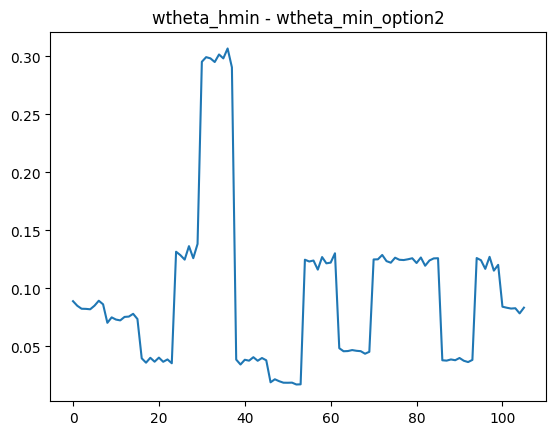

In [14]:
# difference between wtheta_hmin (caclulated from wtheta at h) and wtheta_min_option2 (residual calculation)
# for all simulations

plt.plot(wtheta_hmin - wtheta_min_option2)
plt.title("wtheta_hmin - wtheta_min_option2")
plt.show()

In [15]:
# pulling variables from individual simulations to compare their w_theta calculation differences

# variables for "Ug8Q006_IV.nc"
hmin_r1, wtheta_hmin_r1, h_r1, dtheta_ml_dt_r1, wtheta_sfc_r1 = make_gvars(folder_path, ['Ug8Q006_IV.nc'], 15)

# variables for "Ug16Q006_I.nc"
hmin_r2, wtheta_hmin_r2, h_r2, dtheta_ml_dt_r2, wtheta_sfc_r2 = make_gvars(folder_path, ['Ug16Q006_I.nc'], 15)

# variables for "Ug2Q01_III.nc"
hmin_r3, wtheta_hmin_r3, h_r3, dtheta_ml_dt_r3, wtheta_sfc_r3 = make_gvars(folder_path, ['Ug2Q01_III.nc'], 15)

# wtheta_min
wtheta_min_option2_r1 = wtheta_hmin_r1 - (hmin_r1 * dtheta_ml_dt_r1)
wtheta_min_option2_r2 = wtheta_hmin_r2 - (hmin_r2 * dtheta_ml_dt_r2)
wtheta_min_option2_r3 = wtheta_hmin_r3 - (hmin_r3 * dtheta_ml_dt_r3)

<function matplotlib.pyplot.show(close=None, block=None)>

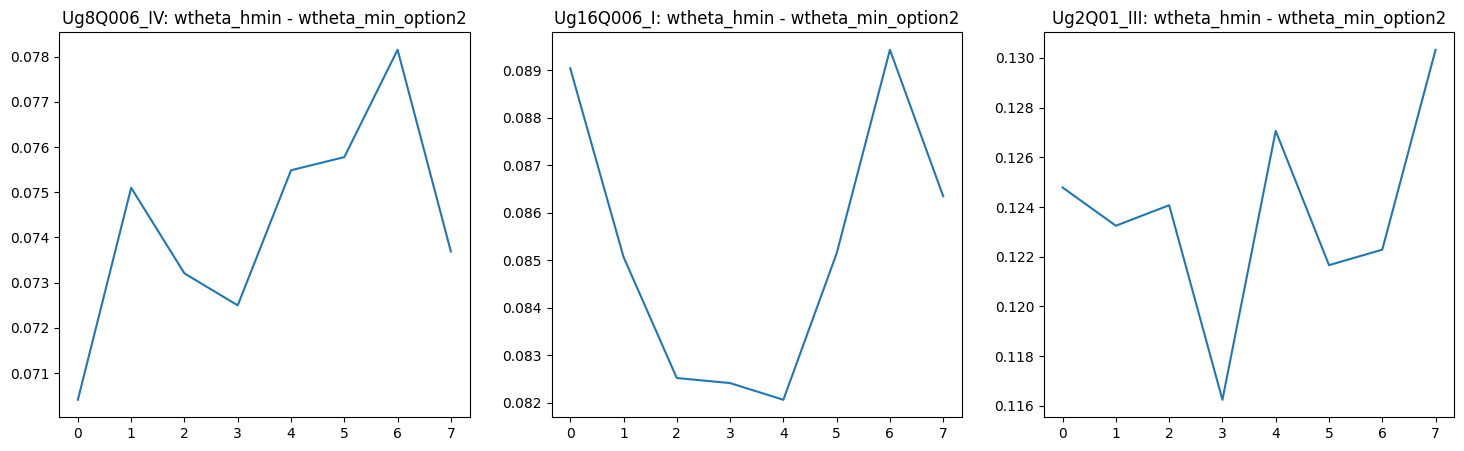

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

#
axs[0].plot(wtheta_hmin_r1 - wtheta_min_option2_r1)
axs[0].set_title('Ug8Q006_IV: wtheta_hmin - wtheta_min_option2')

# Second plot
axs[1].plot(wtheta_hmin_r2 - wtheta_min_option2_r2)
axs[1].set_title('Ug16Q006_I: wtheta_hmin - wtheta_min_option2')

# Third plot
axs[2].plot(wtheta_hmin_r3 - wtheta_min_option2_r3)
axs[2].set_title('Ug2Q01_III: wtheta_hmin - wtheta_min_option2')


plt.show

### Estimating Entrainment Flux

From the textbook:
$$ h^-\frac{d\theta_{ml}}{dt} = -\overline{w\theta_{h^-}} + \overline{w\theta_{sfc}} $$

Laura's discovered equation:
$$ w_e = 9.961432 * \frac{\overline{w\theta_{sfc}}}{\Delta\theta_\rho} + 0.0009702546*Ug $$

Previous studies assume that the minimum flux equals the entrainment flux, $$\overline{w\theta_{h^-}} = w_e\Delta\theta_\rho $$ Where they say, $w_e\Delta\theta = A\overline{w\theta_{sfc}} $ and $w_e = \frac{A\overline{w\theta_{sfc}}}{\Delta\theta_rho} $

### Next Steps:
Now I want to compare the $\overline{w\theta_{h^-}}$ from the data to the $w_e$ equation Laura found, multiplied by $\Delta\theta_\rho$. In order to do this I need to:
- Calculate $\Delta\theta_\rho$ (by modifying Laura's find_jump second derivative method)
- Pull the Ug value from the file names to also plug into Laura's eq
- Pull/calculate $\overline{w\theta_{sfc}}$ for each file

In [17]:
# Laura's second derivative method to find delta-theta_p
def find_jump(ds, filter_num=.001):
    """
    Inputs: 
    - ds: an xarray Dataset containing 'th' (potential temp) with dimensions 'time' and 'z' (height)
    Returns:
    - ds: a modified xarray Dataset with new variable del_th_sd & only the time coordinate
    """
    #making an array to store all the values of th_jump
    th_jump = np.array([])

    #prepping ds
    ds_jump = ds.copy()
    ds_jump = ds_jump[["th"]]

    #looping through every time and calculating th_jump
    for i in range(len(ds_jump.time)):

        #calculating the second derivate using np.diff
        #(central diff)
        diff_df = np.diff(ds_jump.isel(time=i).th, n=2)

        #putting the array into a dataframe to preserve the index
        #(height var)
        diff_df = pd.DataFrame(diff_df)
        diff_df = diff_df.reset_index()
        diff_df = diff_df.rename(columns={"index": "z", 0:"sec_der"})

        #chopping off the beginning and end of the df
        diff_df = diff_df.iloc[50:350]

        #filtering the df to only select for heights
        #with big enough second derivatives
        diff_df = diff_df[np.abs(diff_df["sec_der"]) >= filter_num]

        if len(diff_df) == 0:
            return "Try different filter num, everything filtered out"
        

        #getting the heights
        if (diff_df.z.iloc[1] - diff_df.z.iloc[0]) <= 1:
            min_z = diff_df.z.iloc[0]
        #making sure to cut off tails of sparse values
        else:
            j = 1
            while (diff_df.z.iloc[j+1] - diff_df.z.iloc[j]) >= 2:
                min_z = diff_df.z.iloc[j]
                j+=1

        
        if (diff_df.z.iloc[-1] - diff_df.z.iloc[-2]) <= 1:
            max_z = diff_df.z.iloc[-1]
        #making sure to cut off tails of sparse values
        else:
            j=-2
            while (diff_df.z.iloc[j] - diff_df.z.iloc[j-1]) >=2:
                max_z = diff_df.z.iloc[j]
                j-=1
        
        #calc th_jump
        jump = (ds_jump.isel(time=i, z=max_z).th.values - ds_jump.isel(time=i, z=min_z).th.values)
        if jump < 0:
            return f"Error in calculation: th_jump at time={i} is negative"

        #adding values to array
        if len(th_jump) == 0:
            th_jump = np.array([jump])
        else:
            th_jump = np.concatenate((th_jump, np.array([jump])))

    if len(th_jump) != len(ds_jump.time):
        return "Error in code"
    
    #adding array of th_jumps to the original ds, index is time
    ds = ds.assign(del_th_sd=(['time'],th_jump))


    return ds

Utilizing Laura's find_jump funciton above, I now compare $\overline{w\theta_{h^-}} $ with the right hand side of the equation, $w_e\Delta\theta_{\rho} $ 

In [26]:
# comparing wtheta at h- with w_e * deltheta_p for "Ug16Q006_I.nc"

# extracting wtheta_hmin_f1 (f1 represents file 1:Ug16Q006_I)
hmin_f1, wtheta_hmin_f1, h_f1, dtheta_ml_dt_f1, wtheta_sfc_f1 = make_gvars(folder_path, ["Ug16Q006_I.nc"], 15)

# getting deltheta_p using laura's second-derivative method
del_th_f1 = find_jump(read_data(files[0]), .05)
timeavg_del_th_f1 = time_average(del_th_f1[["del_th_sd"]], 15)
Ug = 16 #hard coding in Ug value until I find a better way to extract

# converting to numpy array
timeavg_del_th_np = timeavg_del_th_f1.to_array()

#calculating w_e
w_e_np = 9.961432 * (wtheta_sfc_f1 / timeavg_del_th_np) + (0.0009702546 * Ug)

# right hand side of equation
# rhs_f1 = w_e_np * timeavg_del_th_f1['del_th_sd'].values
rhs_f1 = w_e_np * timeavg_del_th_np

# comparing lhs and rhs
dif_f1 = wtheta_hmin_f1 - rhs_f1

print("For Ug16Q006_I")
print("wtheta_hmin: ", wtheta_hmin_f1)
print("wtheta_sfc: ", wtheta_sfc_f1)
print("w_e: ", w_e_np)
print("rhs: ", rhs_f1)
print("difference btwn sides: ", dif_f1)

For Ug16Q006_I
wtheta_hmin:  [-0.02176679 -0.02402852 -0.0227475  -0.01909418 -0.01912026 -0.02194497
 -0.02516051 -0.02229727]
wtheta_sfc:  [0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06]
w_e:  [[0.11596726936970236 0.11992493162436249 0.1260300150062052
  0.13309358282858577 0.1314571992519851 0.13911827394965798
  0.18801371957672705 0.28565622904445687]]
rhs:  [[0.6900617164953412 0.6865599042501922 0.6816499140956399
  0.6766053632522796 0.6777193026900911 0.6727583763572891
  0.6514776717264523 0.63203399750487]]
difference btwn sides:  [[-0.7118285110599469 -0.7105884238897134 -0.7043974179860777
  -0.695699546563919 -0.6968395590930214 -0.6947033461067272
  -0.6766381861010756 -0.654331264095529]]


<function matplotlib.pyplot.show(close=None, block=None)>

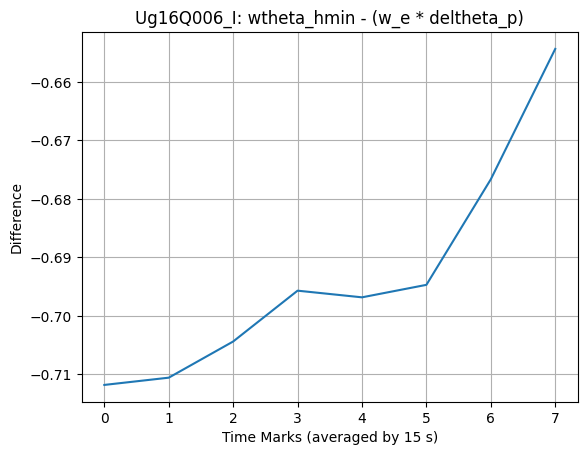

In [30]:
# get values from dif_f1 and flatten
dif_f1_flat = np.array(dif_f1).flatten()

plt.plot(dif_f1_flat)
plt.title('Ug16Q006_I: wtheta_hmin - (w_e * deltheta_p)')
plt.xlabel('Time Marks (averaged by 15 s)')
plt.ylabel('Difference')
plt.grid(True)
plt.show

In [ ]:
# write a function that extracts the Ug (wind) strength from the data

In [15]:
# testing cell

heights = []

for item in items: 
    example_df = nc.Dataset(os.path.join(folder_path, files[8]), mode='r')
    height = example_df.groups['thermo']['zi'][:]
    height_timeavg = time_avg_gen(height, 15)
    heights.append(height_timeavg)

print(height_timeavg)

[ 981.8 1012.6 1038.6 1064.2 1079.8 1099.  1114.2 1127.8]


In [35]:
# testing cell

example_df = nc.Dataset(os.path.join(folder_path, files[8]), mode='r')
theta = example_df['thermo']['th'][:]
theta.shape
theta_ml = theta[:, 75] #first dimension time
print(theta_ml)
print(theta_ml.shape)
# z = example_df.variables['z'][:]
# print(len(z))

[300.33174273 300.33545596 300.33871879 300.34217788 300.34562128
 300.34970681 300.35315968 300.35545155 300.35868315 300.36179184
 300.36508245 300.36934337 300.37230625 300.37543384 300.37822955
 300.38080518 300.38370657 300.38725758 300.39086969 300.39425342
 300.39750002 300.40076656 300.40352227 300.4064058  300.40928366
 300.41252302 300.41532447 300.41766764 300.4204621  300.4232935
 300.42621418 300.42962697 300.43286015 300.43549057 300.43836768
 300.441242   300.44399067 300.44641983 300.44917674 300.45193495
 300.45421005 300.4568614  300.46012555 300.46358951 300.4669838
 300.47009987 300.47300404 300.47543486 300.47822175 300.48149536
 300.48513228 300.48865146 300.4923327  300.49529803 300.49913038
 300.50195566 300.50480171 300.50773058 300.51039684 300.51303023
 300.51627987 300.52025694 300.52356023 300.52688871 300.52972877
 300.53212455 300.53420489 300.53670472 300.53879421 300.54205914
 300.54488782 300.54784974 300.5508123  300.55373107 300.55701162
 300.5603887